# 这个程序由浅入深是有四个部分，分别是
## 一.用cnn做从一到九这九个字符中随机挑出一个的识别模型
## 二.用cnn做从keys中随便挑20来个字的数据集中挑出一个字的识别模型
## 三.用cnn做从一到九这九个字符中随机抽4个字的识别模型
## 四.从cnn做从keys中挑选255个字符组成4个字的识别模型

# 整个程序运行耗时2.5h左右

In [1]:
from modelarts.session import Session
sess = Session()

if sess.region_name == 'cn-north-1':
    bucket_path="modelarts-labs/notebook/DL_ocr_crnn_sequence_recognition/crnn.tar"
elif sess.region_name == 'cn-north-4':
    bucket_path="modelarts-labs-bj4/notebook/DL_ocr_crnn_sequence_recognition/crnn.tar"
else:
    print("请更换地区到北京一或北京四")

sess.download_data(bucket_path=bucket_path, path="./crnn.tar")

Successfully download file modelarts-labs/notebook/DL_ocr_crnn_sequence_recognition/crnn.tar from OBS to local ./crnn.tar


In [2]:
!tar -xf crnn.tar
!pip install keras==2.1.6
!pip install captcha

    100% |████████████████████████████████| 348kB 104.0MB/s ta 0:00:01
  Found existing installation: Keras 2.2.0
    Uninstalling Keras-2.2.0:
      Successfully uninstalled Keras-2.2.0
You are using pip version 9.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 102kB 78.4MB/s a 0:00:01
You are using pip version 9.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
characters = '一二三四五六七八九'

## 第一部分(用cnn做从一到九这九个字符挑选一个的识别模型)

In [4]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

width, height, n_len, n_class = 128, 64, 1, len(characters)

In [5]:
import tensorflow as tf
import tensorflow.keras.backend as K

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

In [6]:
from tensorflow.keras.utils import Sequence
##定义一个Sequence的类，用这个类去生成数据集
##最后返回验证码的array,以及验证码的概率矩阵
class CaptchaSequence(Sequence):
    def __init__(self, characters, batch_size, steps, n_len, width=128, height=64):
        self.characters = characters
        self.batch_size = batch_size
        self.steps = steps
        self.n_len = n_len
        self.width = width
        self.height = height
        self.n_class = len(characters)
        self.generator = ImageCaptcha(width=width, height=height,fonts=a)
    
    def __len__(self):
        return self.steps

    def __getitem__(self, idx):
        X = np.zeros((self.batch_size, self.height, self.width, 3), dtype=np.float32)
        y = [np.zeros((self.batch_size, self.n_class), dtype=np.uint8) for i in range(self.n_len)]
        for i in range(self.batch_size):
            random_str = ''.join([random.choice(self.characters) for j in range(self.n_len)])
            X[i] = np.array(self.generator.generate_image(random_str)) / 255.0
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, self.characters.find(ch)] = 1
        return X, y

Text(0.5,1,'三')

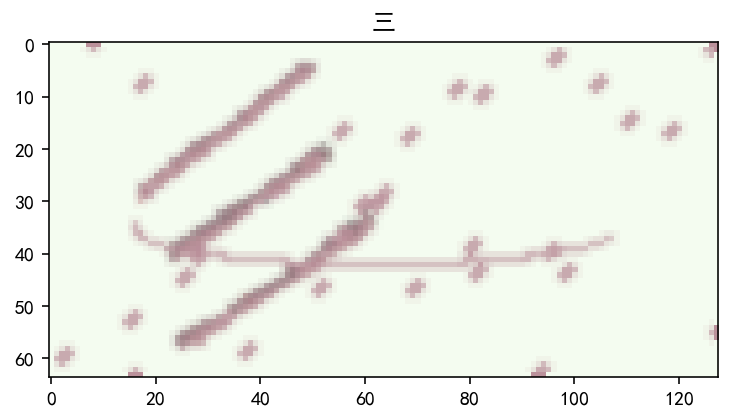

In [7]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

a = ['msyhl.ttc']
data = CaptchaSequence(characters, batch_size=10, steps=2,n_len=n_len)
X, y = data[1]
plt.imshow(X[0])
plt.title(decode(y))

In [8]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i, n_cnn in enumerate([2, 2, 2, 2, 2]):
    for j in range(n_cnn):
        x = Conv2D(32*2**min(i, 3), kernel_size=3, padding='same', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]
model = Model(inputs=input_tensor, outputs=x)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import *

train_data = CaptchaSequence(characters, batch_size=128,steps=1000,n_len=n_len)
valid_data = CaptchaSequence(characters, batch_size=128, steps=100,n_len=n_len)
es = EarlyStopping(monitor='acc',min_delta=0.01,patience=2,verbose=1)
callbacks = [es, CSVLogger('中文数字1个字符cnn.csv'), ModelCheckpoint('中文数字1个字符cnn_best.h5', save_best_only=True)]


In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-3, amsgrad=True), 
              metrics=['accuracy'])
model.fit_generator(train_data, epochs=5, validation_data=valid_data, workers=4, use_multiprocessing=True,callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.


Epoch 1/5
1000/1000 [==============================] - 96s 96ms/step - loss: 0.0924 - acc: 0.9740 - val_loss: 0.0019 - val_acc: 0.9997
Epoch 2/5
1000/1000 [==============================] - 88s 88ms/step - loss: 4.0467e-04 - acc: 0.9999 - val_loss: 5.0988e-05 - val_acc: 1.0000
Epoch 3/5
1000/1000 [==============================] - 87s 87ms/step - loss: 2.8085e-04 - acc: 0.9999 - val_loss: 2.6265e-05 - val_acc: 1.0000
Epoch 4/5
1000/1000 [==============================] - 87s 87ms/step - loss: 3.1463e-05 - acc: 1.0000 - val_loss: 7.8593e-05 - val_acc: 0.9999
Epoch 00004: early stopping


(-0.5, 127.5, 63.5, -0.5)

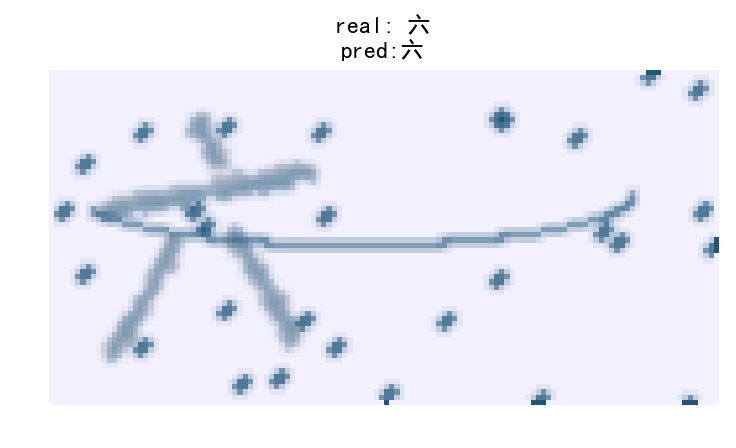

In [11]:
X, y = data[0]
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(list(y_pred.reshape(n_len,10,n_class)))))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

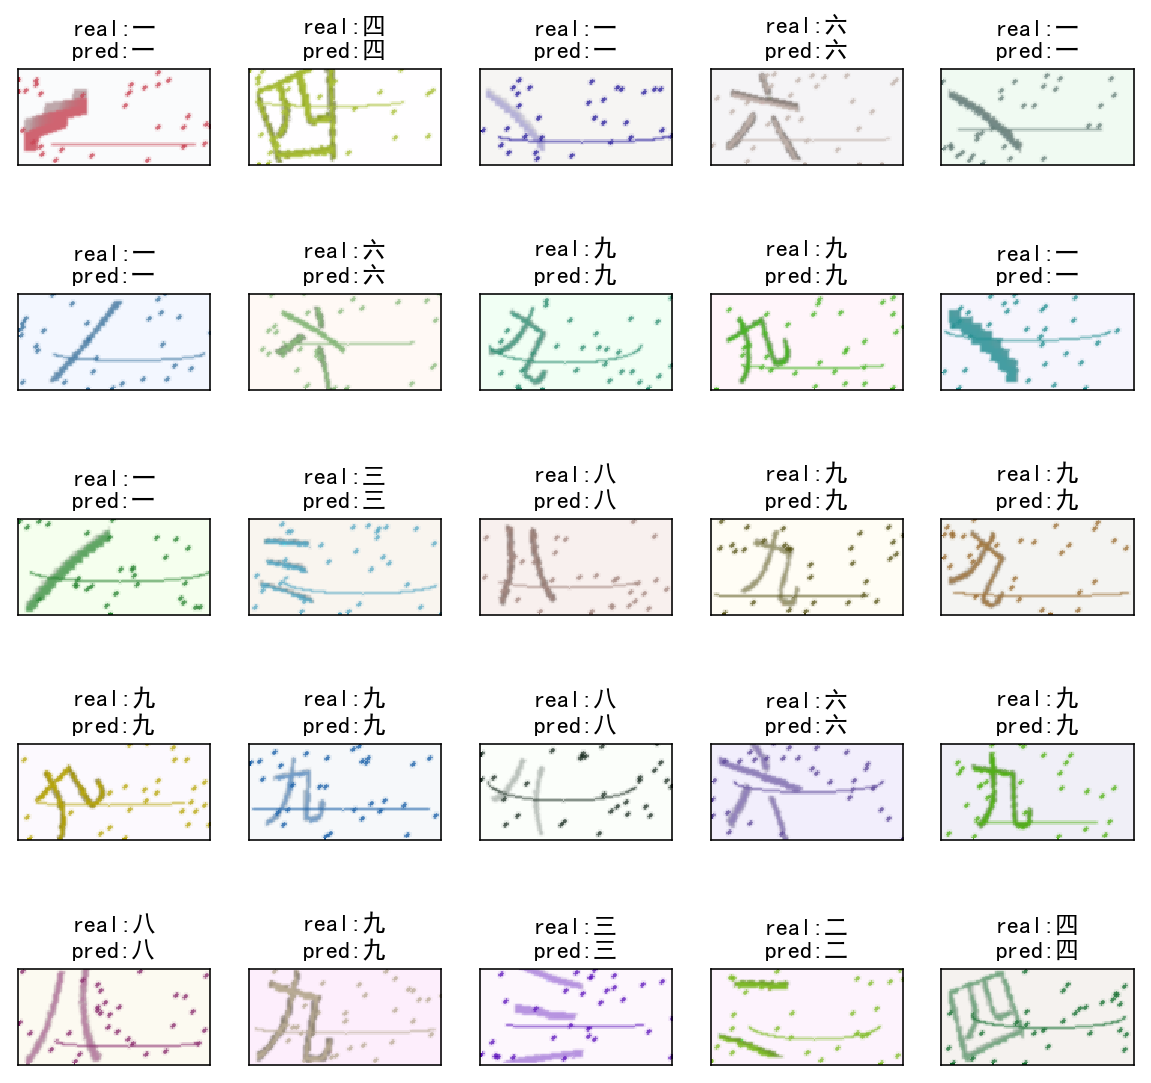

In [12]:
##模型效果可视化一下
test_data = CaptchaSequence(characters,batch_size=128,steps=100,n_len=n_len)

test_x,test_y = test_data[0]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    img_x,img_y = test_data[i]
    y_pred = model.predict(img_x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_x[0])
    plt.title('real:{}\npred:{}'.format(decode(img_y),decode(list(y_pred.reshape(n_len,128,n_class)))))
    

## 第二部分(cnn做从keys中的20个字中随机挑选一个字的识别模型)

In [14]:
import keys

In [17]:
characters = keys.alphabet[1:20]

In [25]:
width, height, n_len, n_class = 128, 64, 1, len(characters)

Text(0.5,1,'更')

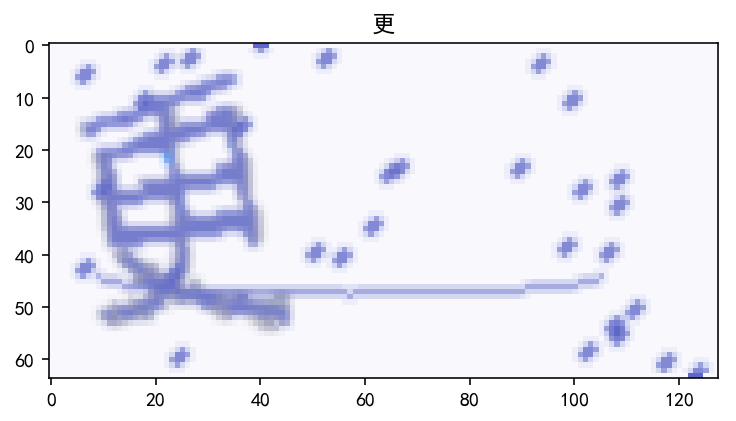

In [26]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

a = ['msyhl.ttc']
data = CaptchaSequence(characters, batch_size=10, steps=2,n_len=n_len)
X, y = data[1]
plt.imshow(X[0])
plt.title(decode(y))

In [27]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i, n_cnn in enumerate([2, 2, 2, 2, 2]):
    for j in range(n_cnn):
        x = Conv2D(32*2**min(i, 3), kernel_size=3, padding='same', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]
model = Model(inputs=input_tensor, outputs=x)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import *

train_data = CaptchaSequence(characters, batch_size=128,steps=1000,n_len=n_len)
valid_data = CaptchaSequence(characters, batch_size=128, steps=100,n_len=n_len)
es = EarlyStopping(monitor='acc',min_delta=0.01,patience=2,verbose=1)
callbacks = [es]


In [29]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-3, amsgrad=True), 
              metrics=['accuracy'])
model.fit_generator(train_data, epochs=3, validation_data=valid_data, workers=4, use_multiprocessing=True,callbacks=callbacks)

Epoch 1/5
1000/1000 [==============================] - 90s 90ms/step - loss: 0.2070 - acc: 0.9423 - val_loss: 0.0103 - val_acc: 0.9974
Epoch 2/5
1000/1000 [==============================] - 88s 88ms/step - loss: 0.0027 - acc: 0.9993 - val_loss: 3.5932e-04 - val_acc: 0.9999
Epoch 3/5
1000/1000 [==============================] - 88s 88ms/step - loss: 5.6425e-04 - acc: 0.9999 - val_loss: 0.0084 - val_acc: 0.9970
Epoch 4/5
1000/1000 [==============================] - 88s 88ms/step - loss: 1.8874e-04 - acc: 1.0000 - val_loss: 3.0768e-05 - val_acc: 1.0000
Epoch 00004: early stopping


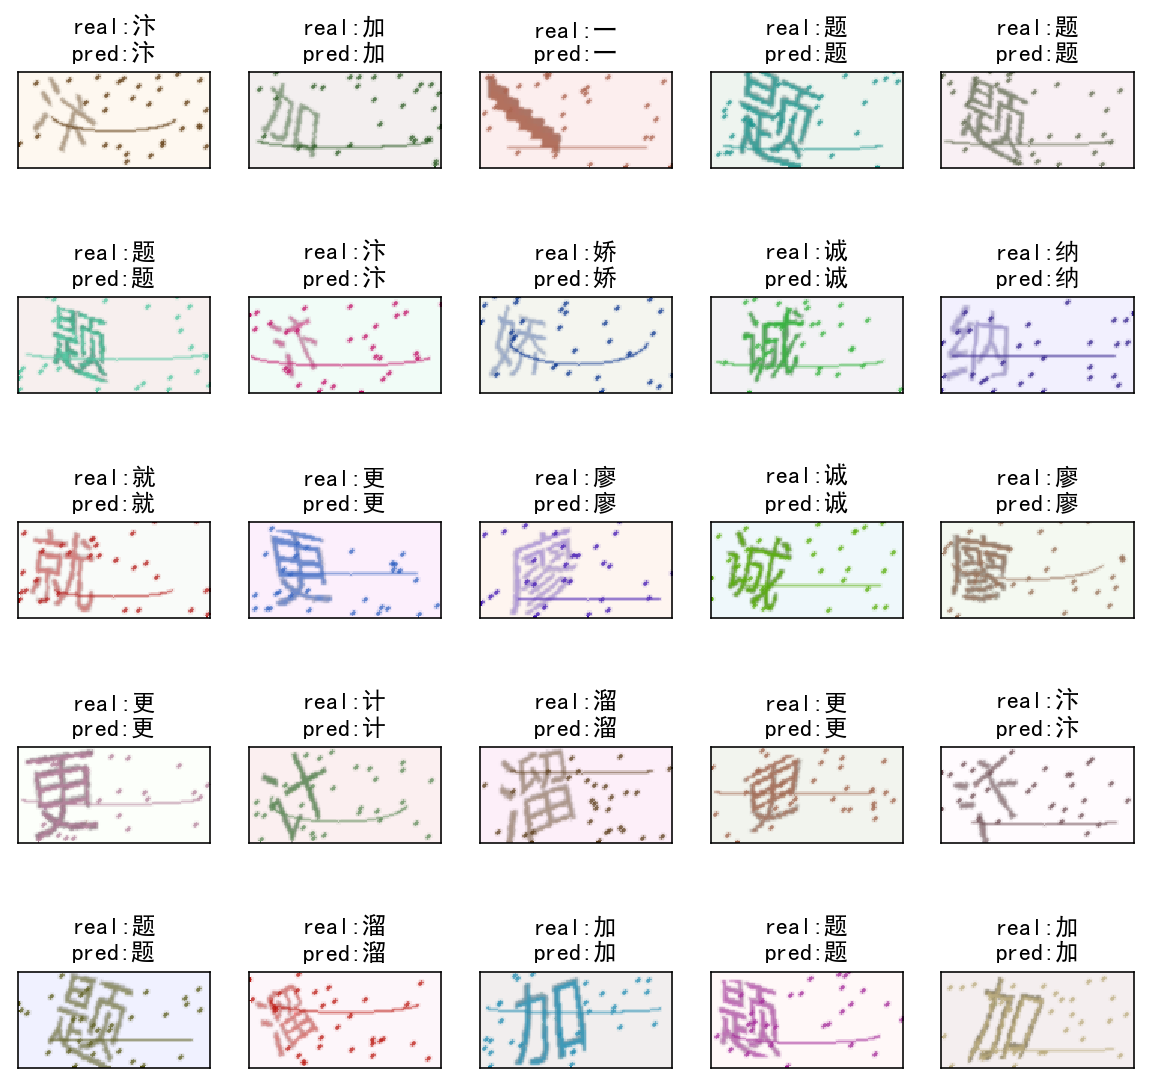

In [31]:
##模型效果可视化一下
test_data = CaptchaSequence(characters,batch_size=50,steps=1,n_len=n_len)

test_x,test_y = test_data[0]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    img_x,img_y = test_data[i]
    y_pred = model.predict(img_x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_x[0])
    plt.title('real:{}\npred:{}'.format(decode(img_y),decode(list(y_pred.reshape(n_len,50,n_class)))))
    

## 第三部分(用cnn从一到九中随意挑出四个字符的识别模型)

Text(0.5,1,'一一三五')

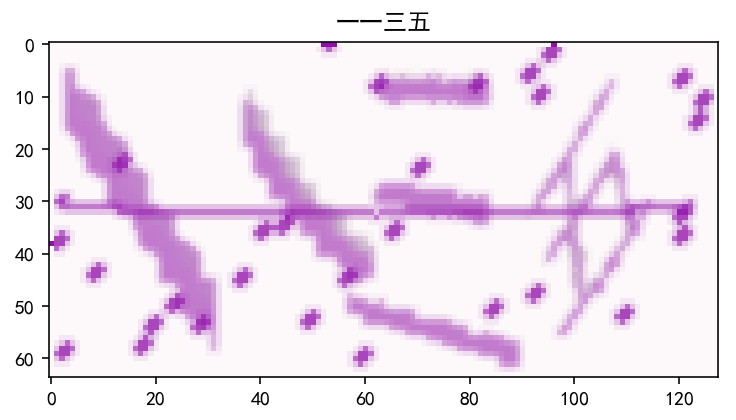

In [32]:
characters = '一二三四五六七八九'
width, height, n_len, n_class = 128, 64, 4, len(characters)

def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

a = ['msyhl.ttc']
data = CaptchaSequence(characters, batch_size=10, steps=2,n_len=n_len)
X, y = data[1]
plt.imshow(X[0])
plt.title(decode(y))

In [33]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i, n_cnn in enumerate([2, 2, 2, 2, 2]):
    for j in range(n_cnn):
        x = Conv2D(32*2**min(i, 3), kernel_size=3, padding='same', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]
model = Model(inputs=input_tensor, outputs=x)

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import *

train_data = CaptchaSequence(characters, batch_size=128,steps=1000,n_len=n_len)
valid_data = CaptchaSequence(characters, batch_size=128, steps=100,n_len=n_len)
es = EarlyStopping(monitor='c4_acc',min_delta=0.01,patience=2,verbose=1)
callbacks = [es]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-3, amsgrad=True), 
              metrics=['accuracy'])
model.fit_generator(train_data, epochs=5, validation_data=valid_data, workers=4, use_multiprocessing=True,callbacks=callbacks)


Epoch 1/5
100/100 [==============================] - 14s 135ms/step - loss: 1.7572 - c1_loss: 0.2458 - c2_loss: 0.2668 - c3_loss: 0.5384 - c4_loss: 0.7062 - c1_acc: 0.9307 - c2_acc: 0.9269 - c3_acc: 0.8826 - c4_acc: 0.8566


1000/1000 [==============================] - 148s 148ms/step - loss: 1.0352 - c1_loss: 0.2390 - c2_loss: 0.2690 - c3_loss: 0.2744 - c4_loss: 0.2528 - c1_acc: 0.9095 - c2_acc: 0.9020 - c3_acc: 0.9006 - c4_acc: 0.9076 - val_loss: 1.7572 - val_c1_loss: 0.2458 - val_c2_loss: 0.2668 - val_c3_loss: 0.5384 - val_c4_loss: 0.7062 - val_c1_acc: 0.9307 - val_c2_acc: 0.9269 - val_c3_acc: 0.8826 - val_c4_acc: 0.8566
Epoch 2/5
100/100 [==============================] - 14s 135ms/step - loss: 0.0132 - c1_loss: 0.0017 - c2_loss: 0.0034 - c3_loss: 0.0028 - c4_loss: 0.0052 - c1_acc: 0.9997 - c2_acc: 0.9991 - c3_acc: 0.9991 - c4_acc: 0.9986


1000/1000 [==============================] - 145s 145ms/step - loss: 0.0093 - c1_loss: 0.0011 - c2_loss: 0.0033 - c3_loss: 0.0034 - c4_loss: 0.0015 - c1_acc: 0.9998 - c2_acc: 0.9992 - c3_acc: 0.9991 - c4_acc: 0.9997 - val_loss: 0.0132 - val_c1_loss: 0.0017 - val_c2_loss: 0.0034 - val_c3_loss: 0.0028 - val_c4_loss: 0.0052 - val_c1_acc: 0.9997 - val_c2_acc: 0.9991 - val_c3_acc: 0.9991 - val_c4_acc: 0.9986
Epoch 3/5
100/100 [==============================] - 13s 132ms/step - loss: 0.5954 - c1_loss: 0.0251 - c2_loss: 0.0778 - c3_loss: 0.1668 - c4_loss: 0.3257 - c1_acc: 0.9923 - c2_acc: 0.9769 - c3_acc: 0.9573 - c4_acc: 0.9183


1000/1000 [==============================] - 145s 145ms/step - loss: 0.0044 - c1_loss: 4.7252e-04 - c2_loss: 0.0017 - c3_loss: 0.0016 - c4_loss: 6.2443e-04 - c1_acc: 0.9999 - c2_acc: 0.9996 - c3_acc: 0.9996 - c4_acc: 0.9999 - val_loss: 0.5954 - val_c1_loss: 0.0251 - val_c2_loss: 0.0778 - val_c3_loss: 0.1668 - val_c4_loss: 0.3257 - val_c1_acc: 0.9923 - val_c2_acc: 0.9769 - val_c3_acc: 0.9573 - val_c4_acc: 0.9183
Epoch 4/5
100/100 [==============================] - 13s 135ms/step - loss: 0.1936 - c1_loss: 0.0235 - c2_loss: 0.0276 - c3_loss: 0.0662 - c4_loss: 0.0763 - c1_acc: 0.9923 - c2_acc: 0.9918 - c3_acc: 0.9816 - c4_acc: 0.9802


1000/1000 [==============================] - 145s 145ms/step - loss: 0.0034 - c1_loss: 6.9005e-04 - c2_loss: 0.0012 - c3_loss: 0.0011 - c4_loss: 4.2466e-04 - c1_acc: 0.9998 - c2_acc: 0.9996 - c3_acc: 0.9997 - c4_acc: 0.9999 - val_loss: 0.1936 - val_c1_loss: 0.0235 - val_c2_loss: 0.0276 - val_c3_loss: 0.0662 - val_c4_loss: 0.0763 - val_c1_acc: 0.9923 - val_c2_acc: 0.9918 - val_c3_acc: 0.9816 - val_c4_acc: 0.9802
Epoch 5/5
100/100 [==============================] - 13s 132ms/step - loss: 0.0096 - c1_loss: 3.5523e-04 - c2_loss: 8.6630e-04 - c3_loss: 0.0068 - c4_loss: 0.0016 - c1_acc: 0.9998 - c2_acc: 0.9998 - c3_acc: 0.9976 - c4_acc: 0.9995


1000/1000 [==============================] - 145s 145ms/step - loss: 0.0029 - c1_loss: 2.8905e-04 - c2_loss: 9.3182e-04 - c3_loss: 0.0012 - c4_loss: 4.5387e-04 - c1_acc: 0.9999 - c2_acc: 0.9997 - c3_acc: 0.9997 - c4_acc: 0.9999 - val_loss: 0.0096 - val_c1_loss: 3.5523e-04 - val_c2_loss: 8.6630e-04 - val_c3_loss: 0.0068 - val_c4_loss: 0.0016 - val_c1_acc: 0.9998 - val_c2_acc: 0.9998 - val_c3_acc: 0.9976 - val_c4_acc: 0.9995


In [36]:
y_pred

[array([[9.13153713e-08, 1.17333752e-06, 1.52485109e-05, 9.99896526e-01,
         5.96833124e-05, 5.91172800e-09, 1.87471630e-06, 2.36668020e-05,
         1.70463716e-06],
        [2.77144818e-09, 1.80584685e-08, 1.53194679e-09, 3.89698869e-08,
         2.12193481e-08, 2.23079528e-08, 9.99999762e-01, 1.40666799e-07,
         2.97638825e-09],
        [1.85849214e-09, 1.27272781e-09, 3.95102653e-08, 4.63783872e-11,
         4.52456383e-08, 1.00000000e+00, 6.10418105e-10, 3.22189636e-10,
         1.32000224e-08],
        [1.45767972e-05, 1.44826117e-07, 9.99939203e-01, 3.62628930e-06,
         1.00186571e-05, 2.98719042e-05, 2.46174500e-06, 2.63841553e-08,
         5.73643284e-08],
        [1.84360740e-08, 7.04317848e-09, 9.99999642e-01, 1.37815860e-07,
         1.59332657e-07, 1.34378482e-07, 2.99380326e-10, 3.43369583e-10,
         6.28913532e-10],
        [1.23605062e-07, 2.48790233e-08, 3.43044810e-08, 1.82468554e-07,
         1.02470983e-06, 2.21441084e-07, 9.99998450e-01, 5.31624345

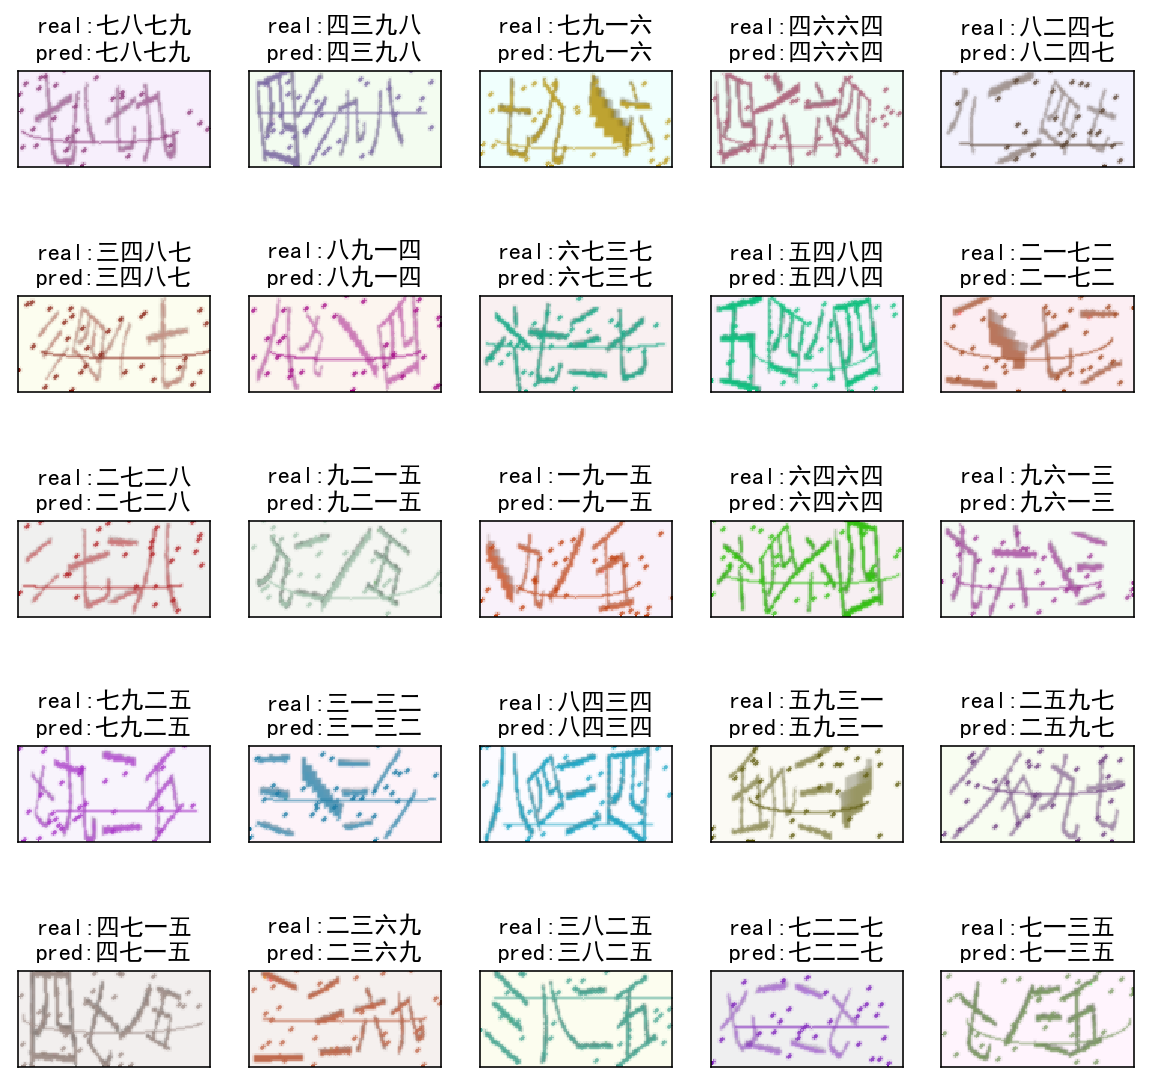

In [38]:
##模型效果可视化一下
test_data = CaptchaSequence(characters,batch_size=50,steps=1,n_len=n_len)

test_x,test_y = test_data[0]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    img_x,img_y = test_data[i]
    y_pred = model.predict(img_x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_x[0])
    plt.title('real:{}\npred:{}'.format(decode(img_y),decode(y_pred)))

## 第四部分(从keys中挑选255个构成数据集,再挑选4个构成验证码,用cnn识别)

Text(0.5,1,'让夕馀钇')

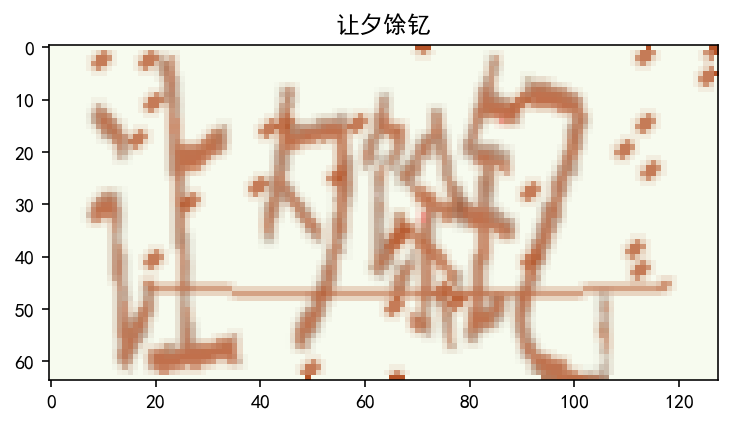

In [40]:
characters = keys.alphabet[1:255]
width, height, n_len, n_class = 128, 64, 4, len(characters)

def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

a = ['msyhl.ttc']
data = CaptchaSequence(characters, batch_size=10, steps=2,n_len=n_len)
X, y = data[1]
plt.imshow(X[0])
plt.title(decode(y))

In [41]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i, n_cnn in enumerate([2, 2, 2, 2, 2]):
    for j in range(n_cnn):
        x = Conv2D(32*2**min(i, 3), kernel_size=3, padding='same', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]
model = Model(inputs=input_tensor, outputs=x)

In [42]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import *

train_data = CaptchaSequence(characters, batch_size=128,steps=1000,n_len=n_len)
valid_data = CaptchaSequence(characters, batch_size=128, steps=100,n_len=n_len)
es = EarlyStopping(monitor='c4_acc',min_delta=0.01,patience=2,verbose=1)
callbacks = [es]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-3, amsgrad=True), 
              metrics=['accuracy'])
model.fit_generator(train_data, epochs=5, validation_data=valid_data, workers=4, use_multiprocessing=True,callbacks=callbacks)


Epoch 1/5
1000/1000 [==============================] - 171s 171ms/step - loss: 20.2583 - c1_loss: 4.9950 - c2_loss: 5.1128 - c3_loss: 5.1204 - c4_loss: 5.0302 - c1_acc: 0.0365 - c2_acc: 0.0281 - c3_acc: 0.0281 - c4_acc: 0.0340 - val_loss: 40.3112 - val_c1_loss: 9.6342 - val_c2_loss: 9.0428 - val_c3_loss: 9.0440 - val_c4_loss: 12.5903 - val_c1_acc: 0.0077 - val_c2_acc: 0.0073 - val_c3_acc: 0.0059 - val_c4_acc: 0.0048
Epoch 2/5
1000/1000 [==============================] - 168s 168ms/step - loss: 2.5833 - c1_loss: 0.5073 - c2_loss: 0.7715 - c3_loss: 0.7654 - c4_loss: 0.5391 - c1_acc: 0.8583 - c2_acc: 0.7941 - c3_acc: 0.7945 - c4_acc: 0.8488 - val_loss: 7.9193 - val_c1_loss: 0.8879 - val_c2_loss: 1.0303 - val_c3_loss: 2.0762 - val_c4_loss: 3.9249 - val_c1_acc: 0.7941 - val_c2_acc: 0.7563 - val_c3_acc: 0.6335 - val_c4_acc: 0.4603
Epoch 3/5
1000/1000 [==============================] - 169s 169ms/step - loss: 0.4372 - c1_loss: 0.0661 - c2_loss: 0.1470 - c3_loss: 0.1497 - c4_loss: 0.0743 - c1_

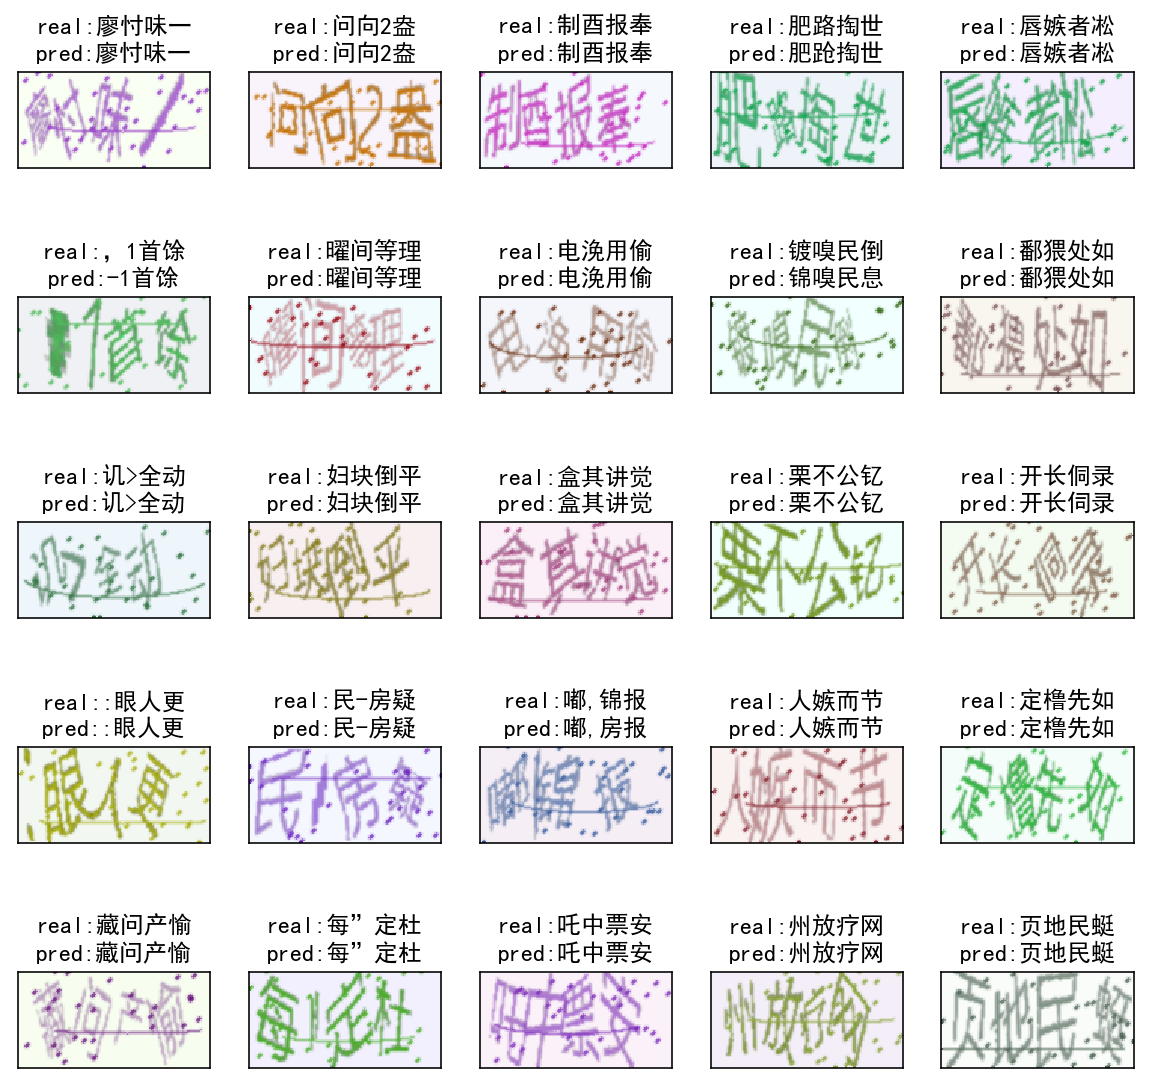

In [44]:
##模型效果可视化一下
test_data = CaptchaSequence(characters,batch_size=50,steps=1,n_len=n_len)

test_x,test_y = test_data[0]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    img_x,img_y = test_data[i]
    y_pred = model.predict(img_x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_x[0])
    plt.title('real:{}\npred:{}'.format(decode(img_y),decode(y_pred)))
    

In [58]:
test_data = CaptchaSequence(characters,batch_size=100,steps=1,n_len=n_len)
acc = 0
test_x,test_y = test_data[0]
for i in range(100):
    img_x,img_y = test_data[i]
    y_pred = model.predict(img_x)
    if(decode(img_y)==decode(y_pred)):
        acc += 1
print('正确率为:{}%'.format(acc))

正确率为:85%


In [ ]:
##以上为cnn模型训练5轮的准确性